In [1]:
import numpy as np
from scipy.signal import lfilter, firwin
from pylab import *
from scipy.fftpack import fft,fftshift
import scipy.signal as signal
from tool._fixedInt import *

In [2]:
#------------------------------------------------
# Create a signal for demonstration.
#------------------------------------------------
# 320 samples of (1000Hz + 15000 Hz) at 48 kHz

sample_rate = 48000.
nsamples = 1024

F_1KHz = 1500.
A_1KHz = 1.0
 
F_15KHz = 17000.
A_15KHz = 0.5
 
t = np.arange(nsamples) / sample_rate

noise  = A_15KHz * np.sin(2*np.pi*F_15KHz*t)
data = A_1KHz  * np.sin(2*np.pi*F_1KHz*t)
signal_gen = data + noise
 
    
    
# FFT
NFFT = 1024
fs = sample_rate

fft_signal     = fft(data,NFFT)
fft_signal_gen = fft(signal_gen,NFFT)
xfft           = np.linspace(0.0, 1.0/(2.0*t[1]), NFFT//2)

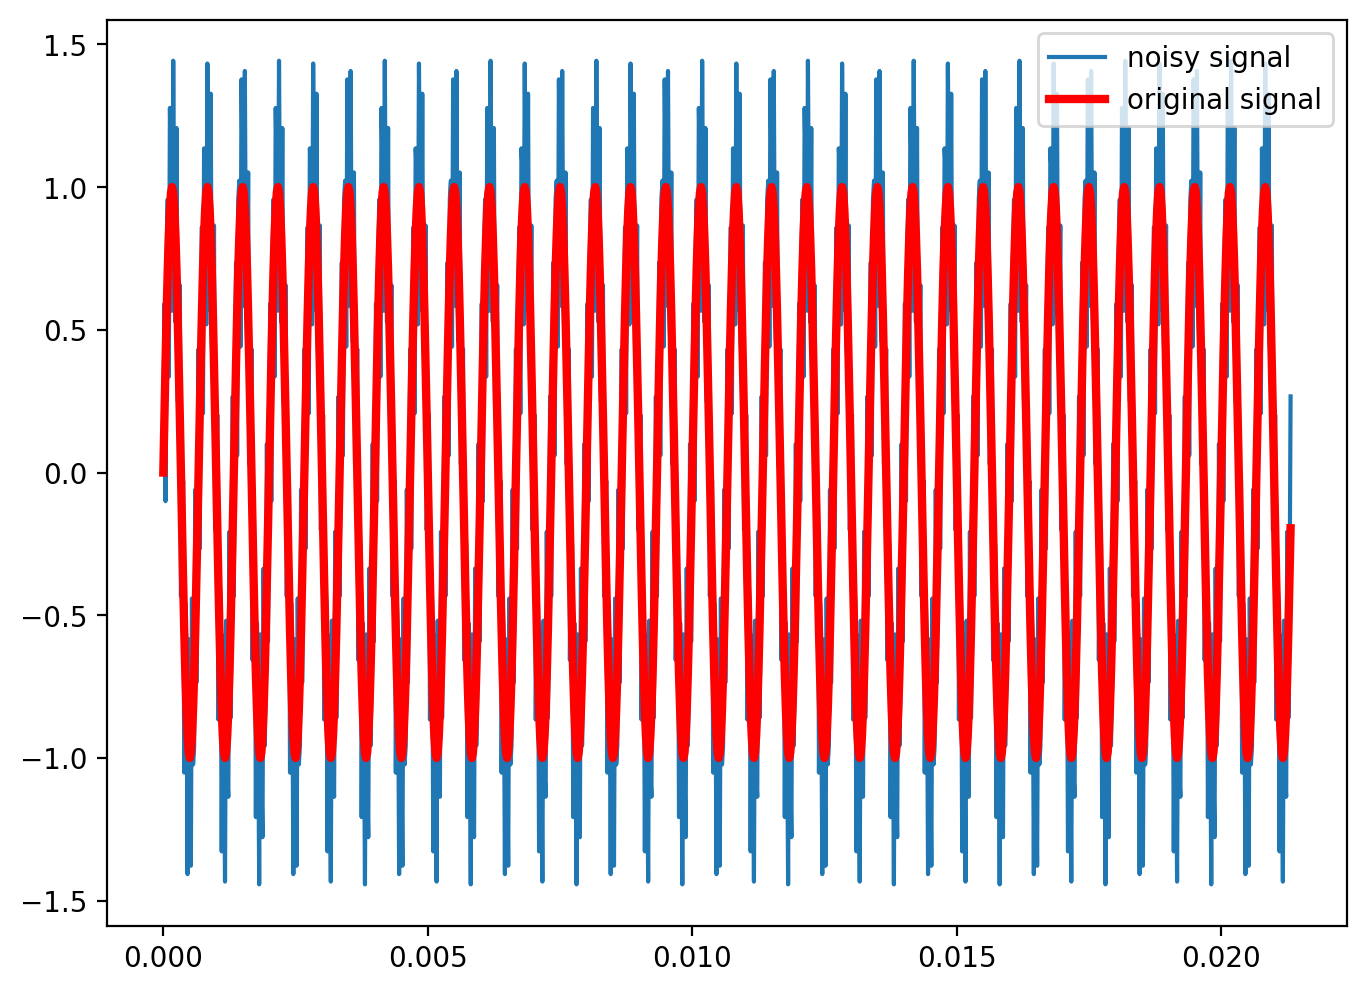

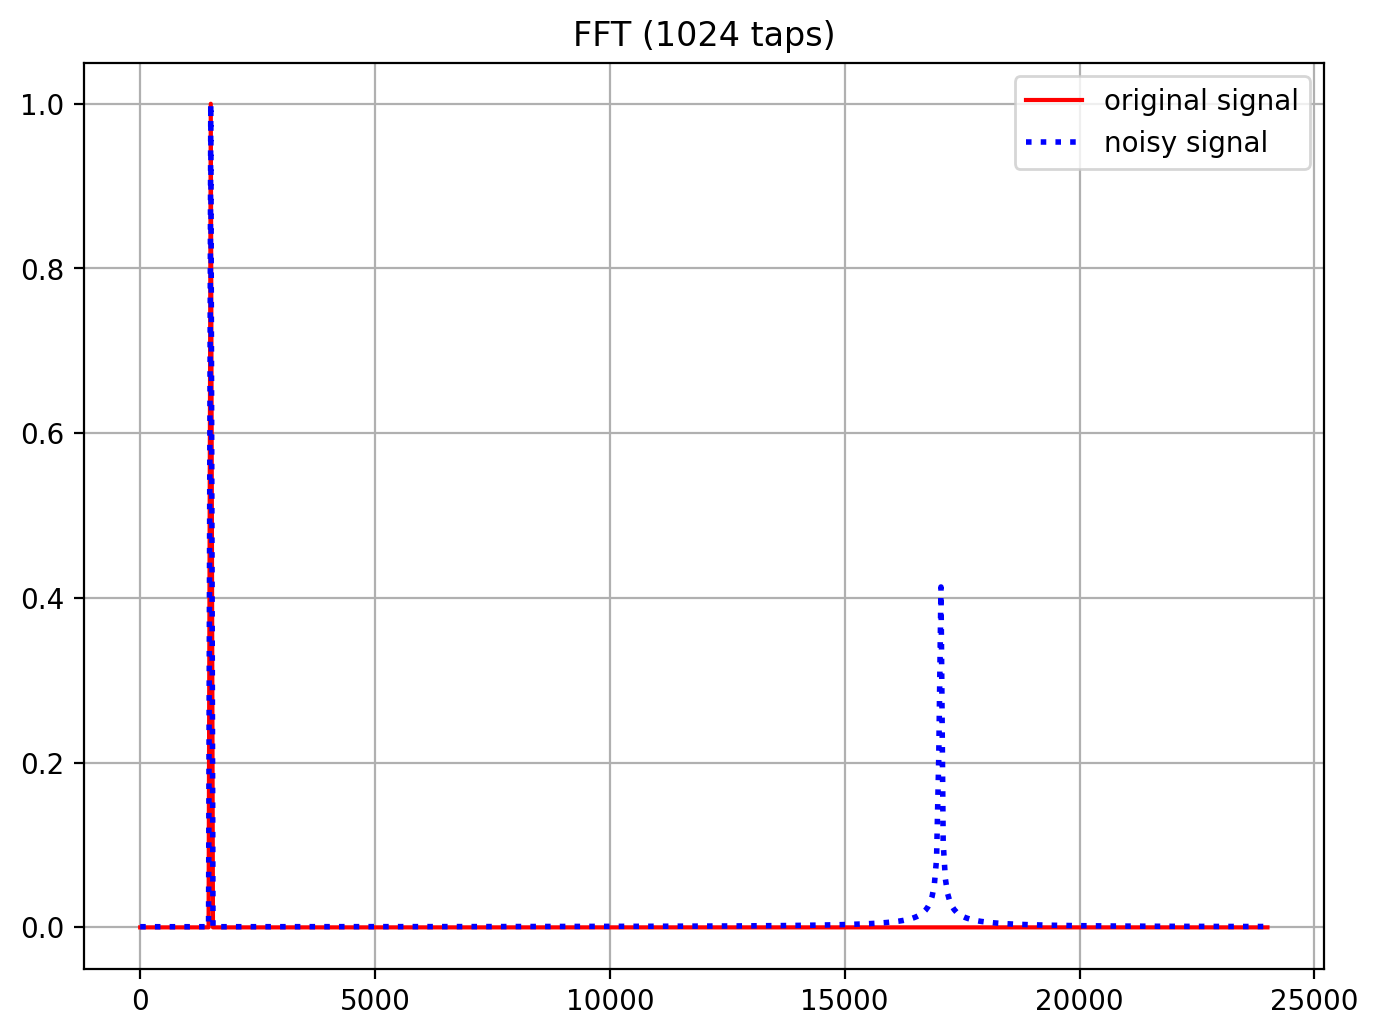

In [3]:
#------------------------------------------------
# Plot signals
#------------------------------------------------
figure(1, figsize=(8, 6), dpi=200)

# Plot the noisy signal and original signal
plot(t, signal_gen, label='noisy signal')
plot(t, data, 'r-', linewidth=3, label='original signal') 

legend()


# FFT PLOT
figure(2, figsize=(8, 6), dpi=200)
title('FFT (%d taps)' % NFFT)
plot(xfft,2.0/NFFT * np.abs(fft_signal[0:NFFT//2]),'r-', label='original signal')
plot(xfft,2.0/NFFT * np.abs(fft_signal_gen[0:NFFT//2]),'b:' ,linewidth=2, label='noisy signal')


legend()

grid(True)
show()

In [44]:
#------------------------------------------------
# Create a FIR filter and apply it to signal.
#------------------------------------------------
# The Nyquist rate of the signal.
nyq_rate = sample_rate / 2.
 
# The cutoff frequency of the filter: 6KHz
cutoff_hz = 8000.0
 
# Length of the filter (number of coefficients, i.e. the filter order + 1)
numtaps = 15
 
# Use firwin to create a lowpass FIR filter
fir_coeff = firwin(numtaps, cutoff_hz/nyq_rate)
 
# Use lfilter to filter the signal with the FIR filter
filtered_signal = lfilter(fir_coeff, 1.0, signal_gen)

# FFT
fft_filtered_signal = fft(filtered_signal,NFFT)


# Filter Response
w, h = signal.freqz(fir_coeff)

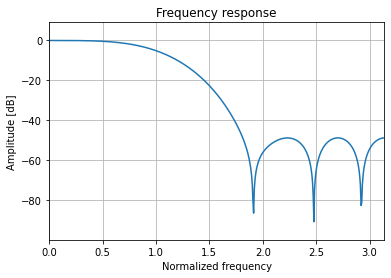

In [45]:
plt.figure()

plt.title('Frequency response')
plt.xlabel('Normalized frequency')
plt.ylabel('Amplitude [dB]')
plt.margins(0, 0.1)
plt.grid(True, color = '0.7', linestyle='-', which='major', axis='both')
plt.grid(True, color = '0.9', linestyle='-', which='minor', axis='both')
plt.plot(w, 20*log10(abs(h)))
plt.show()


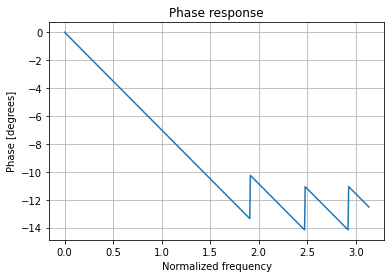

In [46]:
plt.figure()

plt.title('Phase response')
plt.xlabel('Normalized frequency')
plt.ylabel('Phase [degrees]')
plt.grid(True, color = '0.7', linestyle='-', which='major')
plt.grid(True, color = '0.9', linestyle='-', which='minor')
plt.plot(w, unwrap(angle(h)))
show()



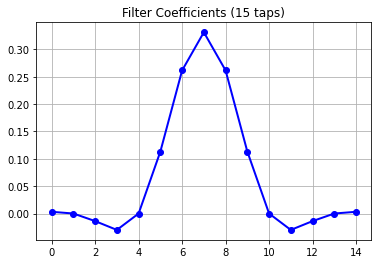

In [47]:
#------------------------------------------------
# Plot the FIR filter coefficients.
#------------------------------------------------
figure(1)
plot(fir_coeff, 'bo-', linewidth=2)
title('Filter Coefficients (%d taps)' % numtaps)
grid(True)

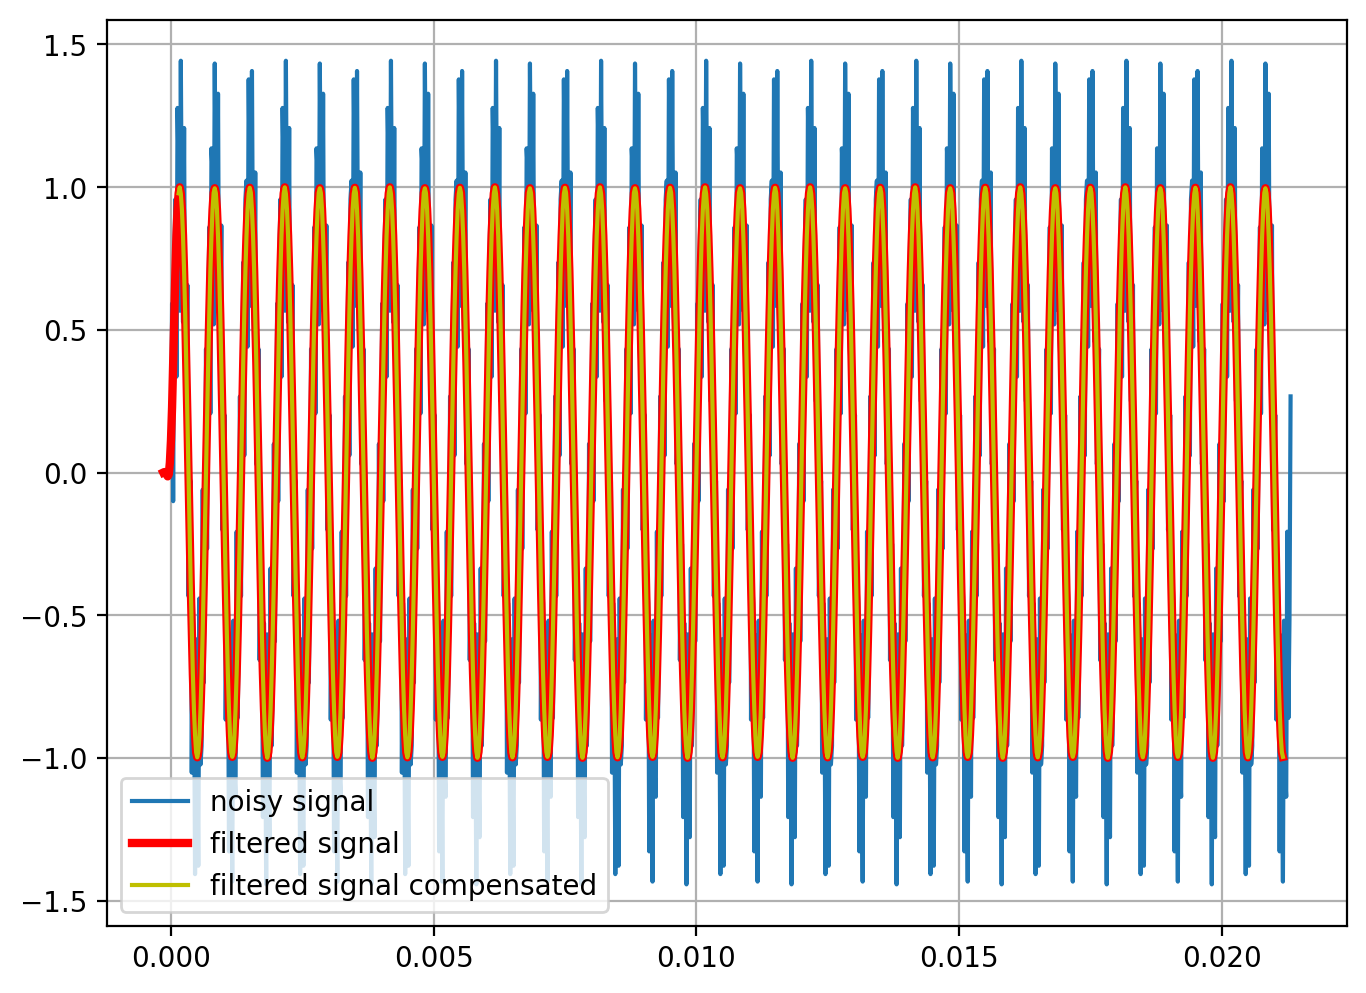

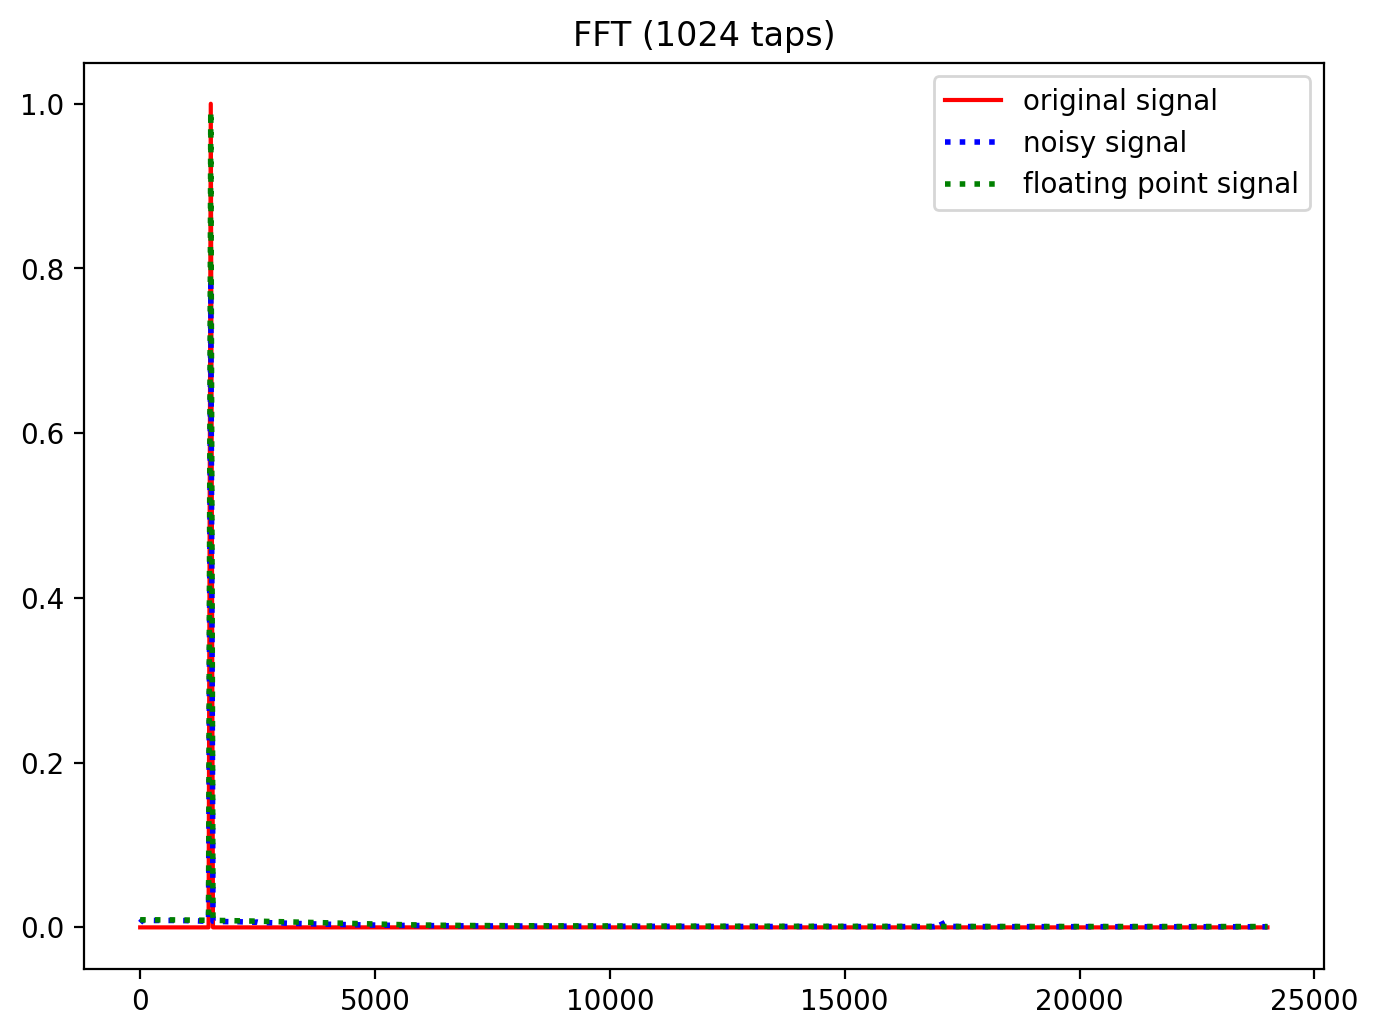

In [48]:
#------------------------------------------------
# Plot the original and filtered signals.
#------------------------------------------------
 
# The first N-1 samples are "corrupted" by the initial conditions
warmup = numtaps - 1
 
# The phase delay of the filtered signal
delay = (warmup / 2) / sample_rate
 
figure(1, figsize=(8, 6), dpi=200)
# Plot the original signal
plot(t, signal_gen, label='noisy signal')
 
# Plot the filtered signal, shifted to compensate for the phase delay
plot(t-delay, filtered_signal, 'r-', linewidth=3 , label='filtered signal')
 
# Plot just the "good" part of the filtered signal.  The first N-1
# samples are "corrupted" by the initial conditions.
plot(t[warmup:]-delay, filtered_signal[warmup:], 'y', label='filtered signal compensated')

legend()

grid(True)


# FFT PLOT
figure(2, figsize=(8, 6), dpi=200)
title('FFT (%d taps)' % NFFT)
plot(xfft,2.0/NFFT * np.abs(fft_signal[0:NFFT//2]),'r-', label='original signal')
plot(xfft,2.0/NFFT * np.abs(fft_signal_gen[0:NFFT//2]),'b:' ,linewidth=2, label='noisy signal')
plot(xfft,2.0/NFFT * np.abs(fft_filtered_signal[0:NFFT//2]),'g:' ,linewidth=2, label='floating point signal')

legend()

show()

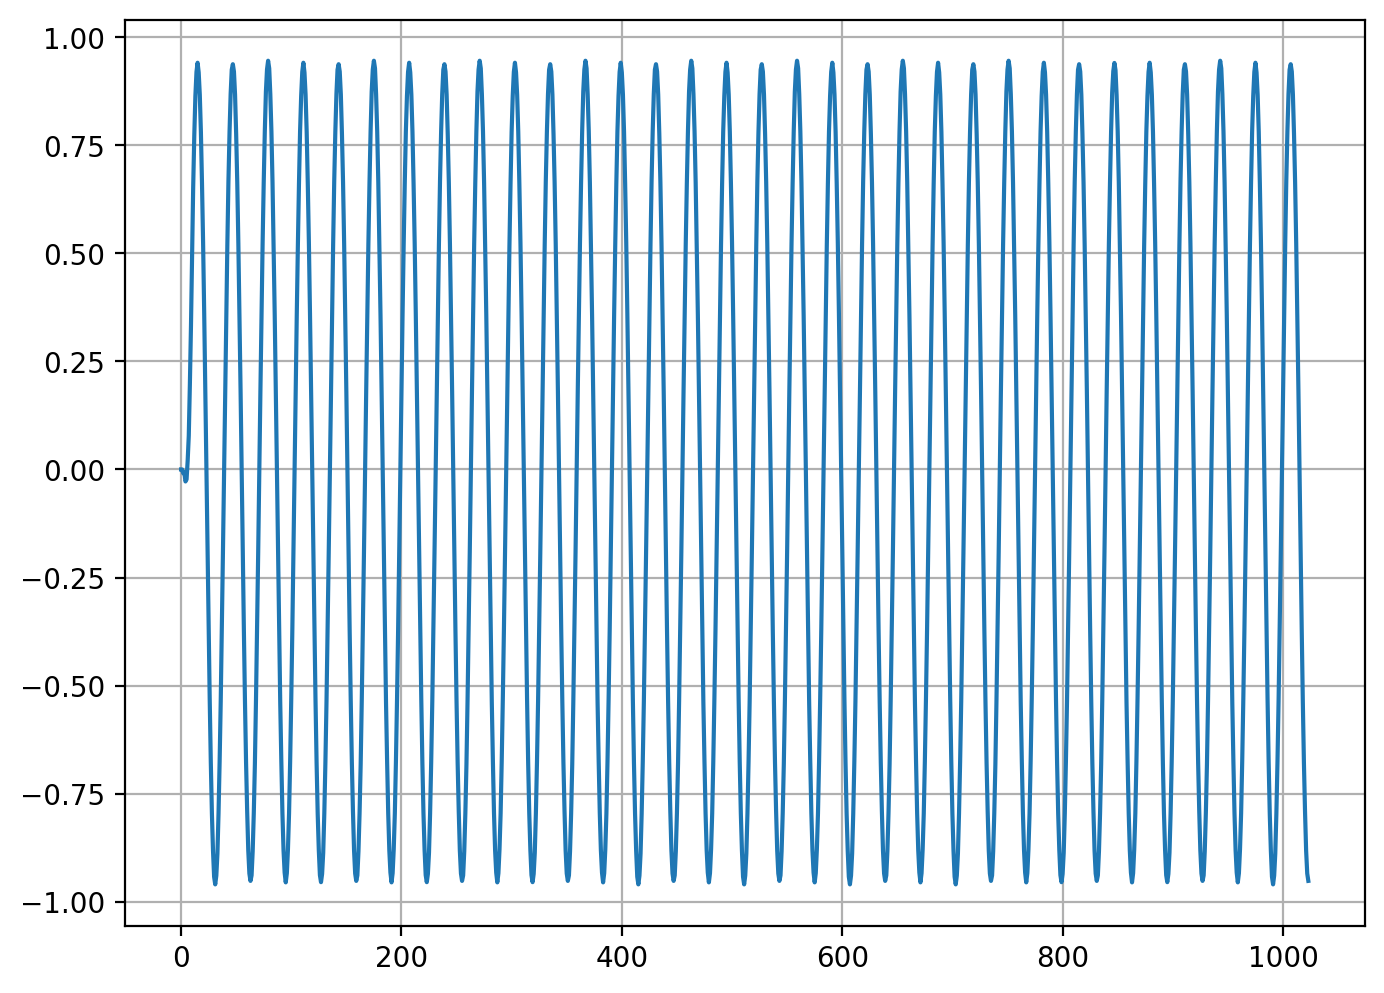

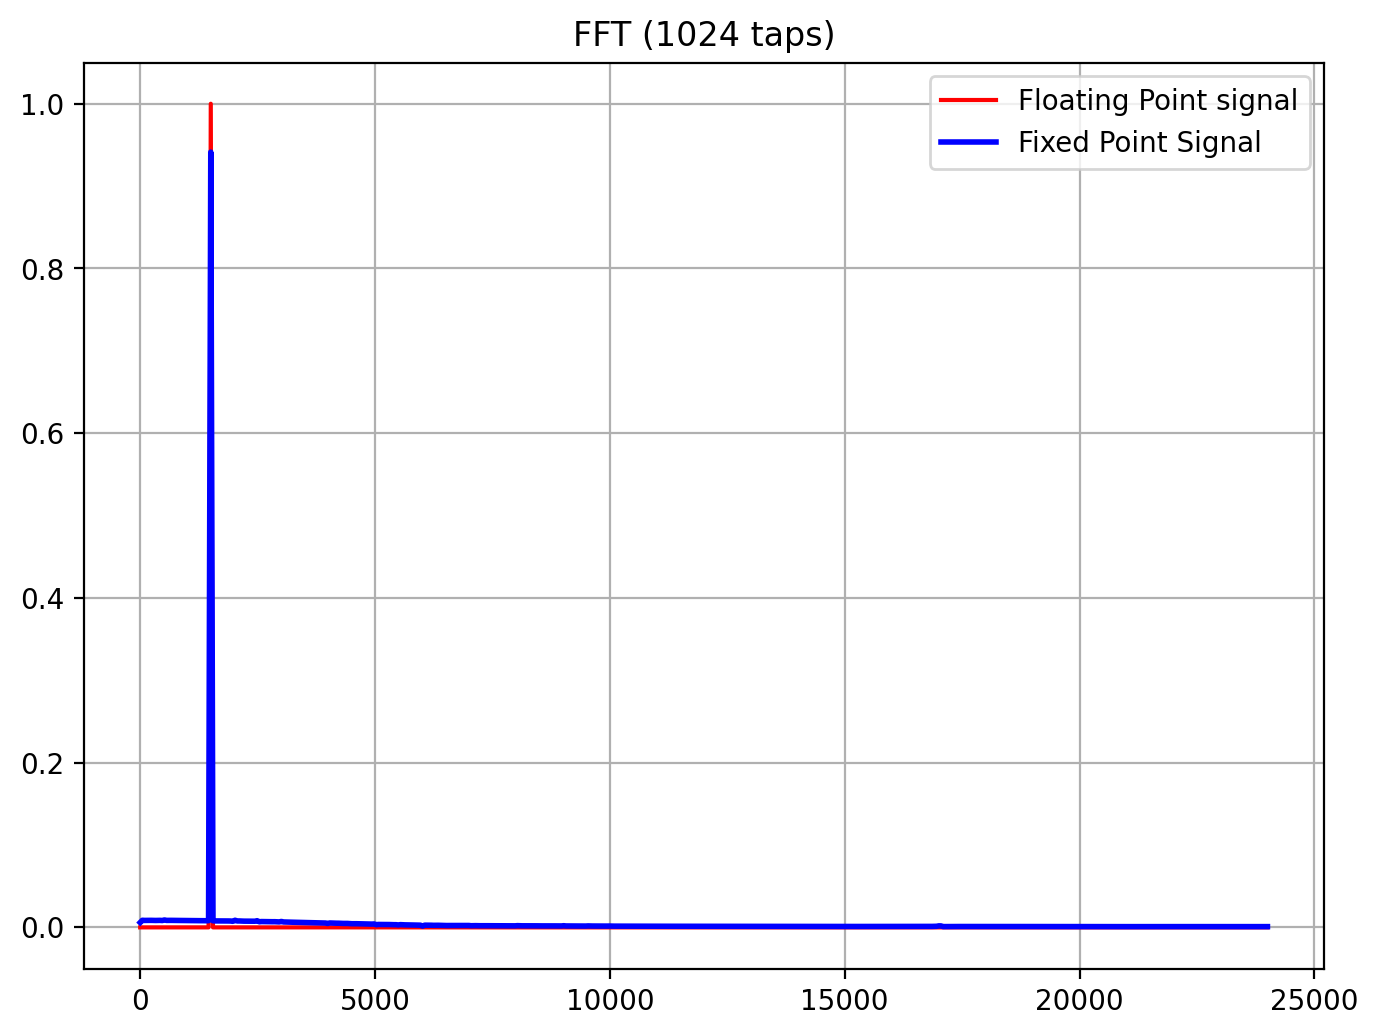

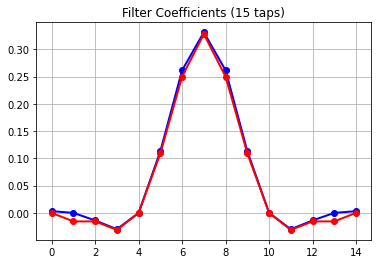

In [49]:
def fir_filter(x,c):
    Xn_Coeff = x * c
    fp_acumulador = Xn_Coeff[0]
    for index in range(1,len(Xn_Coeff)):
        fp_acumulador =  fp_acumulador + Xn_Coeff[index]
    return fp_acumulador


taps= len(fir_coeff)
init_coeff = np.ones(taps)

coeff = arrayFixedInt(8,6,fir_coeff)
xn =  arrayFixedInt(8,6,init_coeff)

value_coeff = [a.fValue for a in coeff]

fp_filtered = []
temp = [0.0]*taps

for value in signal_gen:
    temp.insert(0,value)
    temp.pop()
    for j in range(taps):
        xn[j].value = temp[j]
    Yn = fir_filter(xn,coeff)
    fp_filtered.append(Yn.fValue)
    
    
figure(1, figsize=(8, 6), dpi=200)
plot(fp_filtered)

fft_signal_gen = fft(fp_filtered,NFFT)

# Filter Response
w, h = signal.freqz(value_coeff)

grid(True)


# FFT PLOT
figure(2, figsize=(8, 6), dpi=200)
title('FFT (%d taps)' % NFFT)
plot(xfft,2.0/NFFT * np.abs(fft_signal[0:NFFT//2]),'r-', label='Floating Point signal')
plot(xfft,2.0/NFFT * np.abs(fft_signal_gen[0:NFFT//2]),'b' ,linewidth=2, label='Fixed Point Signal')

legend()

grid(True)

#------------------------------------------------
# Plot the FIR filter coefficients.
#------------------------------------------------
figure(3)
plot(fir_coeff, 'bo-', linewidth=2, label='Floating Point FIR Coeff')
plot(value_coeff, 'ro-', linewidth=2, label='Fixed Point FIR Coeff')

title('Filter Coefficients (%d taps)' % numtaps)
grid(True)


show()


In [50]:
print(fir_coeff)

[ 3.13312811e-03 -1.62247059e-18 -1.38825996e-02 -2.99946357e-02
  8.30086614e-18  1.13333804e-01  2.61660051e-01  3.31500503e-01
  2.61660051e-01  1.13333804e-01  8.30086614e-18 -2.99946357e-02
 -1.38825996e-02 -1.62247059e-18  3.13312811e-03]


In [51]:
coeff

array([<0 (0.000) S(8,6)>, <-1 (-0.016) S(8,6)>, <-1 (-0.016) S(8,6)>,
       <-2 (-0.031) S(8,6)>, <0 (0.000) S(8,6)>, <7 (0.109) S(8,6)>,
       <16 (0.250) S(8,6)>, <21 (0.328) S(8,6)>, <16 (0.250) S(8,6)>,
       <7 (0.109) S(8,6)>, <0 (0.000) S(8,6)>, <-2 (-0.031) S(8,6)>,
       <-1 (-0.016) S(8,6)>, <-1 (-0.016) S(8,6)>, <0 (0.000) S(8,6)>],
      dtype=object)

In [52]:
[a.fValue for a in coeff]

[0.0,
 -0.015625,
 -0.015625,
 -0.03125,
 0.0,
 0.109375,
 0.25,
 0.328125,
 0.25,
 0.109375,
 0.0,
 -0.03125,
 -0.015625,
 -0.015625,
 0.0]

In [53]:
[a.__hex__() for a in coeff]

['0x00',
 '0xFF',
 '0xFF',
 '0xFE',
 '0x00',
 '0x07',
 '0x10',
 '0x15',
 '0x10',
 '0x07',
 '0x00',
 '0xFE',
 '0xFF',
 '0xFF',
 '0x00']